In [8]:
%matplotlib inline

import sys
sys.path.append('../..')

from matplotlib import pylab as plt

import itertools
import numpy
import scipy
import scipy.special
import time
import random

from ipywidgets import interact
from IPython.display import display, Markdown, clear_output

#from crocodile.synthesis import *
#from crocodile.simulate import *
from crocodile.antialias import *
from util.visualize import *
#from arl.test_support import create_named_configuration, export_visibility_to_hdf5
#from arl.data_models import *

SyntaxError: invalid syntax (synthesis.py, line 456)

In [7]:
# Load TBN Data from Cygnus A Transit (thanks Jayce!)

efield_data = numpy.load("edata.npz")
efield_data = efield_data['edata']

naccum, ntime, nchan, nstand, npol = efield_data.shape
#ntime = efield_data.shape[1]
#nchan = efield_data.shape[2]
print(nchan)
efield_data = efield_data.reshape((naccum*ntime*nchan,nstand,npol))

efield_data[:,255,:] = 0.0


print(efield_data.shape)

1
(100000, 256, 2)


In [19]:
efield_data_ss = efield_data[510,:,0]
print(efield_data_ss.shape)

(256,)


In [20]:
#Load E-Field Locations

locations = numpy.load("locations.npz")
locations = locations['locations']

locations[255,:] = 0.0
print(locations.shape)

(256, 3)


In [21]:
# Singular value decomposition to find the 

u,s,vh = numpy.linalg.svd(locations)
print(s.shape)
print(s)

(3,)
[503.31113044 370.58374403  10.64258015]


In [22]:
# Convert Locations to u/v/w from metres
cfreq = 74029999.9919
wl = 3e8/cfreq
locations_uvw = locations/(wl/4)
u,s,vh = numpy.linalg.svd(locations_uvw)
print(s.shape)
for i in numpy.arange(locations_uvw.shape[-1]):
    print(numpy.max(locations_uvw[:,i]))
    print(numpy.min(locations_uvw[:,i]))
print(s)

(3,)
50.47760226114365
-36.89655199596296
68.69983999248319
-39.90513119563377
2.602894799715204
-0.7481965332514693
[496.80163977 365.7908609   10.50493611]


In [23]:
print(locations_uvw)

[[-3.66359664e+01  2.58522631e+01  2.47062787e+00]
 [-3.49569660e+01  1.67475601e+01  2.06198227e+00]
 [-3.42008729e+01  7.87876613e+00  1.71058653e+00]
 [-3.68965520e+01  2.13601227e+00  1.49047067e+00]
 [-3.47585656e+01 -2.91184667e+00  1.27825133e+00]
 [-3.35750727e+01 -9.73050320e+00  1.03345880e+00]
 [-2.96386508e+01  1.06751260e+01  1.74710800e+00]
 [-2.78757497e+01  3.69064227e+00  1.33155293e+00]
 [-2.82370161e+01 -2.41436507e+00  1.26245827e+00]
 [-2.93612851e+01 -7.19867720e+00  1.04629067e+00]
 [-2.27824857e+01 -3.27015187e+00  1.05813547e+00]
 [-2.42729564e+01 -8.86681987e+00  1.02358813e+00]
 [-2.74295956e+01 -1.26759101e+01  9.00204800e-01]
 [-2.87818769e+01 -1.84245864e+01  7.58067200e-01]
 [-1.91402097e+01 -1.02497003e+01  8.37032533e-01]
 [-1.42591651e+01 -1.26581429e+01  5.94214133e-01]
 [-2.22731593e+01 -1.80001477e+01  6.13955467e-01]
 [-2.57091384e+01 -2.23383057e+01  7.42274133e-01]
 [-1.79863288e+01 -2.12584548e+01  4.22464533e-01]
 [-1.96179500e+01 -2.68600581e+

In [24]:
theta = 2.0
lam = 32
grid_size = int(theta*lam)

In [5]:
aa_over = 4096
aa_support = 8
aa_x0 = 0.25
aa_mode = 0
aa_szetan = True
if aa_support == 1:
    print("Using trivial gridder")
    aa_gcf = numpy.ones((aa_over, aa_support))
    def aa(x): return numpy.ones_like(x)
elif aa_szetan:
    print("Using Sze-Tan's gridder with R=%d, x_0=%g" % (aa_support//2, aa_x0))
    aa_gcf = sze_tan_gridder(aa_support//2, aa_x0, aa_over)
    def aa(x):
        return sze_tan_grid_correction_gen(aa_support//2, aa_x0, x)
    print("Mean error:", sze_tan_mean_error(aa_support//2, aa_x0))
else:
    aa_parameter = aa_support
    print("Using PSWF with mode %d and parameter %g" % (aa_mode, aa_parameter))
    aa_gcf = kernel_oversample(anti_aliasing_function(grid_size, aa_mode, aa_parameter), aa_over, aa_support)
    aa_gcf /= numpy.sum(aa_gcf[0])
    def aa(x):
        return scipy.special.pro_ang1(aa_mode, aa_mode, aa_parameter, 2*x)[0]
    
# Calculate appropriate step length to give us full accuracy for a field of view of size theta
du = du_opt = aa_x0/(theta/2)
print("Optimal du =", du)

# Plot gridding function
plt.rcParams['figure.figsize'] = 10, 5
r = numpy.arange(-aa_over*(aa_support//2), aa_over*((aa_support+1)//2)) / aa_over
plt.plot(du_opt*r, numpy.transpose(aa_gcf).flatten().real);
plt.xticks(du_opt*numpy.arange(-(aa_support//2), ((aa_support+1)//2)+1))
plt.grid(True);plt.xlabel('u/v [$\lambda$]');plt.title('$u/v$ Gridder');plt.show()

# Plot grid correction function
theta_x0 = theta/aa_x0/2
x = coordinates(10001)
#print(x)
sze_aa_im = aa(x)
print(sze_aa_im.shape)
plt.plot(theta*x/aa_x0/2, aa(x));
plt.title('$u/v$ Grid correction');plt.grid(True);plt.xlabel('l [1]')
plt.axvspan(theta/2, theta_x0/2, color='lightgray', hatch='x', alpha=0.5)
plt.axvspan(-theta/2, -theta_x0/2, color='lightgray', hatch='x', alpha=0.5)
plt.annotate('(unused)', xy=((theta+theta_x0)/4,0.9), ha='center', color='gray')
plt.annotate('(unused)', xy=(-(theta+theta_x0)/4,0.9), ha='center', color='gray');

Using Sze-Tan's gridder with R=4, x_0=0.25


NameError: name 'sze_tan_gridder' is not defined

Using Sze-Tan's gridder with R=2, x_0=0.125
('Mean error:', 7.125787071239688e-06)
('max_n =', 1.0)
('Optimal dw =', 0.125)


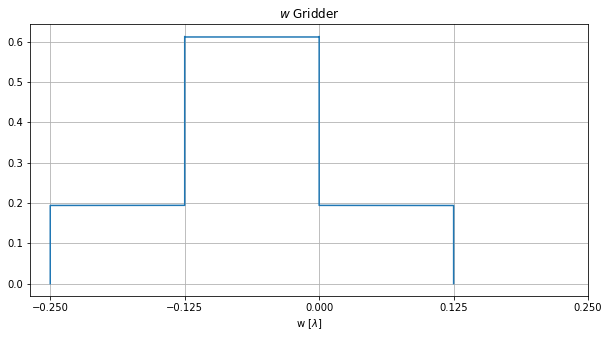

[-0.49995    -0.49985001 -0.49975002 ...  0.49975002  0.49985001
  0.49995   ]
[0.23630141 0.23607546 0.23585053 ... 0.23585053 0.23607546 0.23630141]


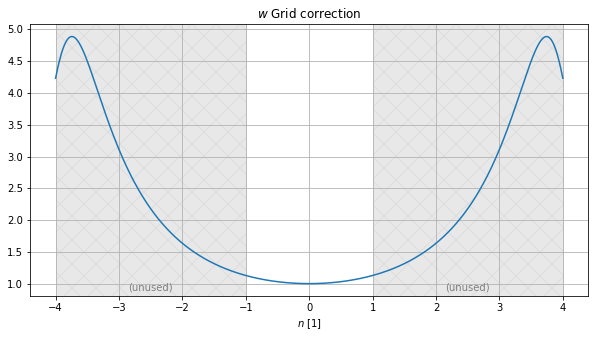

In [13]:
aa_support_w = 4
aa_x0_w = 0.125
aa_parameter_w = aa_support_w
aa_szetan_w = True
if aa_support_w == 1:
    print("Using trivial gridder")
    aa_gcf_w = numpy.ones((aa_over, aa_support_w))
    def aa_w(x): return numpy.ones_like(x)
elif aa_szetan_w:
    print("Using Sze-Tan's gridder with R=%d, x_0=%g" % (aa_support_w//2, aa_x0_w))
    aa_gcf_w = sze_tan_gridder(aa_support_w//2, aa_x0_w, aa_over)
    def aa_w(x):
        return sze_tan_grid_correction_gen(aa_support_w//2, aa_x0_w, x)
    print("Mean error:", sze_tan_mean_error(aa_support_w//2, aa_x0_w))
else:
    aa_gcf_w = kernel_oversample(anti_aliasing_function(grid_size, 0, aa_parameter_w), aa_over, aa_support_w)
    aa_gcf_w /= numpy.sum(aa_gcf_w[0])
    def aa_w(x):
        return scipy.special.pro_ang1(aa_mode, aa_mode, aa_parameter_w, 2*x)[0]

# Calculate appropriate step length to give us full accuracy for a field of view of size theta
max_n = 1.0
print("max_n =", max_n)
dw = dw_opt = aa_x0_w / max_n
print("Optimal dw =", dw)

# Plot gridding function
plt.rcParams['figure.figsize'] = 10, 5
r = numpy.arange(-aa_over*(aa_support_w//2), aa_over*((aa_support_w+1)//2)) / aa_over
plt.plot(dw_opt*r, numpy.transpose(aa_gcf_w).flatten().real);
plt.xticks(dw_opt*numpy.arange(-(aa_support_w//2), ((aa_support_w+1)//2)+1))
plt.grid(True); plt.xlabel('w [$\lambda$]'); plt.title('$w$ Gridder'); plt.show()

x = coordinates(10001)
print(x)
sze_w_im = aa_w(x)
print(sze_w_im)
#plt.plot(max_n*x/aa_x0_w, aa_w(x));
plt.plot(max_n*x/aa_x0_w, 1/aa_w(x));
plt.title('$w$ Grid correction'); plt.grid(True); plt.xlabel('$n$ [1]');
max_n_x0 = max_n/aa_x0_w/2
plt.axvspan(max_n, max_n_x0, color='lightgray', hatch='x', alpha=0.5)
plt.axvspan(-max_n, -max_n_x0, color='lightgray', hatch='x', alpha=0.5)
plt.annotate('(unused)', xy=((max_n+max_n_x0)/2,0.9), ha='center', color='gray')
plt.annotate('(unused)', xy=(-(max_n+max_n_x0)/2,0.9), ha='center', color='gray');

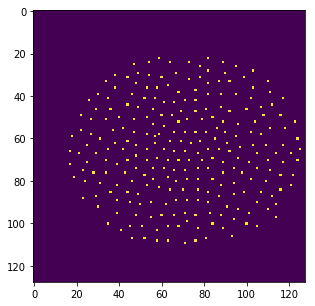

In [14]:
#Plot locations

grid_locs = numpy.zeros(shape=(2*grid_size,2*grid_size))
location_grid_points = (locations_uvw + grid_size).astype(int)
location_grid_points[:,0] = location_grid_points[:,0] -5
location_grid_points[:,1] = location_grid_points[:,1] - 7
#print(location_grid_points)
for i in numpy.arange(location_grid_points.shape[0]):
    grid_locs[location_grid_points[i,0],location_grid_points[i,1]] += 1.0
    
plt.imshow(grid_locs)
plt.show()

In [15]:
phases = numpy.load("phases.npz")
phases = phases['phases']
print(phases.shape)
print(phases)
phasesa = numpy.zeros((naccum*ntime*nchan,nstand,npol),dtype=numpy.complex64)

phasesa[...] = phases
print(phasesa.shape)
print(phasesa[2422,...])

(256, 2)
[[ 1.9004693 +1.9644537j  -0.40693766+2.718632j  ]
 [-1.2725719 -2.6789567j  -2.0660696 +2.1776638j ]
 [-3.1156867 +0.7862076j  -2.237598  -2.3355877j ]
 [-0.41509905-3.4160058j  -0.34906712-3.4229686j ]
 [ 1.1341652 -3.4647143j   3.6576703 +0.37135932j]
 [ 3.7612007 +1.2242706j  -1.7264125 +3.6855793j ]
 [ 1.7824568 +2.7812579j  -1.8232877 +2.7830367j ]
 [ 3.533149  +0.10242062j -2.7178907 -2.3440378j ]
 [-3.4506998 +1.4341985j  -0.7225398 -3.708541j  ]
 [ 3.0465841 -2.5624666j   2.431592  -3.1587617j ]
 [-3.4622085 +1.7430427j  -2.2683868 -3.1854038j ]
 [-3.3881407 +2.2289648j   1.39523   +3.8440607j ]
 [ 4.1799316 +0.945403j   -0.6897725 +4.2705383j ]
 [-3.5852478 +2.801884j    2.9976125 +3.4841835j ]
 [ 1.5807462 -3.9401906j   3.6448107 +2.265966j  ]
 [-2.2528503 -3.8896236j  -4.330659  +1.3381739j ]
 [-4.056953  +2.7029674j  -4.7049723 +0.03787179j]
 [ 2.3286672 +4.3816524j   4.5808597 +1.9610319j ]
 [ 4.31055   -2.4615905j  -2.041941  +4.398386j  ]
 [-5.2640224 +0.561365

In [16]:
# Correct for antenna delays
efield_data = efield_data * phasesa
print(efield_data[1000])


[[-5.04999390e+01+1.46278954e+01j  8.15589619e+00+1.22081304e+00j]
 [-4.61457710e+01-1.41976624e+01j  3.95901031e+01-2.86444130e+01j]
 [ 4.98218460e+01-2.58282757e+01j -2.88927937e+01-3.95090141e+01j]
 [ 1.28338251e+01-8.49240780e+00j -3.66731567e+01-2.04701099e+01j]
 [-2.63968925e+01+2.20468884e+01j  5.08718491e+00+2.26887398e+01j]
 [-2.12545452e+01+1.40104818e+00j -2.55663013e+01-2.98731613e+00j]
 [ 2.95950356e+01-1.50433102e+01j -9.50127983e+00-3.40675583e+01j]
 [-2.89821358e+01+2.39126778e+01j -2.71789074e+00-2.34403777e+00j]
 [ 8.37871647e+00-4.79970894e+01j  1.16564789e+01+4.00714111e+01j]
 [-3.73268852e+01-2.58250237e+01j -7.27169752e-01-5.59035397e+00j]
 [ 5.18137455e+00-6.94829369e+00j  7.33613586e+00-4.36303253e+01j]
 [ 4.45792961e+00+6.77628136e+00j  9.42498112e+00+1.39810123e+01j]
 [ 7.81277990e+00+2.37358665e+01j  6.62592926e+01+2.38479748e+01j]
 [ 1.80464592e+01+3.78709984e+01j  6.48179626e+00+4.86571074e-01j]
 [ 9.48447704e+00-2.36411438e+01j -2.68925190e+01-2.17725372e+

In [ ]:
print(efield_data.shape)
efield_data = efield_data.flatten()
print(efield_data.shape)
efield_data.tofile("efield_phased.bin")

In [ ]:
arr = numpy.array([[1.+2j,2.+2j,3.+2j,4.+2j,5.+2j][1.+2j,2.+2j,3.+2j,4.+2j,5.+2j]],dtype=numpy.complex64)
arr.tofile("floatarr.bin")

In [ ]:
print(efield_data.flatten()[2000])

In [ ]:
efieldp = numpy.load("efield_phased.npy")
print(efieldp[0])
print(efieldp.shape)

In [ ]:
#Image directly from image routines using the EPIC formalism.

def epic_image(efield,locations):
    grid = numpy.zeros(shape=(2*grid_size,2*grid_size),dtype=numpy.complex64)
    image = numpy.zeros(shape=(2*grid_size,2*grid_size),dtype=numpy.complex64)    
    location_grid_points = locations

    for j,efieldd in enumerate(efield):
        for i,e_sample in enumerate(efieldd[:,0]):
            #print("Sample: %d"%i)
            grid[location_grid_points[i,0],location_grid_points[i,1]] += e_sample

        imaged = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.fftshift(grid),s=(2*grid_size,2*grid_size)))
        imaged = imaged * imaged.conj()
        #plt.imshow(numpy.abs(imaged))
        #plt.colorbar()
        #plt.show()
        
        
        
        image += imaged
        grid[...] = 0.0
        if j == 2:
            break
    
    #plt.imshow(grid.real)
    #plt.show()
    #image = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.fftshift(grid)))
    #imsq = image * image.conj()
    plt.imshow(numpy.real(image))
    plt.colorbar()
    plt.show()
    
    
    
epic_image(efield_data[20000:20001,:],location_grid_points)

# Simulate Electric Field

In [ ]:
def simulate_electric_fields(locations_uvw,points):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    for i in numpy.arange(256):
        for point in points:
            elec_ss[i] += point[2]*numpy.exp(2j*numpy.pi*(locations_uvw[i,0]*point[0]+locations_uvw[i,1]*point[1]))
    return elec_ss

def epic_image_snapshot(efield,locations):
    grid = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex64)
    image = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex64)    
    location_grid_points = locations

    for j,efieldd in enumerate(efield):
            grid[location_grid_points[j,0],location_grid_points[j,1]] += efieldd

    imaged = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.fftshift(grid),s=(grid_size,grid_size)))
    imaged = imaged * imaged.conj()
    image += imaged
    grid[...] = 0.0
        
    #plt.imshow(grid.real)
    #plt.show()
    #image = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.fftshift(grid)))
    #imsq = image * image.conj()
    plt.imshow(numpy.real(image))
    plt.colorbar()
    plt.show()

points = numpy.zeros(shape=(3,3))

points[0,0] = 0.01
points[0,1] = -0.01
points[1,0] = 0.01
points[1,1] = 0.01
points[0,2] = 0
points[1,2] = 0

points[2,0] = 0.03
points[2,2] = 1000

eefs = simulate_electric_fields(locations_uvw,points)  

epic_image_snapshot(eefs,location_grid_points)

# Optimal Gridding

Let's do things a la Sze Tan and co. Optimal kernels are already generated.

In [ ]:
max_w = numpy.sin(theta/2) * numpy.sqrt(grid_size**2 + grid_size**2)
max_w = numpy.max(locations_uvw[:,2]) - numpy.min(locations_uvw[:,2])
w_planes = 2*numpy.ceil(max_w/(2*dw)) + aa_support_w

print("Stacking Parameters: ")
print(max_w)
print(w_planes)

In [ ]:
# Generating a fresnel pattern for such a large field of view is problematic...
def generate_fresnel(theta,lam,dw,x0):
    grid_size = int(theta*lam)
    x0ih = 0.5/x0
    oversampg = x0ih * grid_size
    print(oversampg)
    grid_size = int(theta * lam)
    ls,ms = theta*coordinates2(x0ih*grid_size)
    r2 = ls**2 + ms**2
    r2[r2>1.0] = 0.0
    ns = numpy.sqrt(1 - r2) - 1.0
    ns = numpy.nan_to_num(ns)
    
    #Fresnel Pattern
    
    ph = 1 - numpy.sqrt(1.0 -r2)
    frnl = numpy.exp(2j * numpy.pi * dw * ph)
    
    return(frnl)

generate_fresnel(theta,lam,dw_opt,aa_x0)

In [ ]:
# Prove it for a snapshot first.
# Also extend to Y polarisation too!
def epic_wstack(theta,lam,efield,locations,x0,du=du_opt,dw=dw_opt,
                gcf_support=aa_gcf,gcf_support_w=aa_gcf_w, aa=aa, aa_w=aa_w):
    
    grid_size = int(theta*lam)
    #max_w = numpy.sin(theta/2) * numpy.sqrt(grid_size**2 + grid_size**2)
    max_w = numpy.max(locations[:,2]) - numpy.min(locations[:,2]) 
    w_planes = 2*numpy.ceil(max_w/(2*dw)) + aa_support_w
    w_min = numpy.min(locations[:,2])
    #Fresnel Pattern
    fresnel_pattern = generate_fresnel(theta,lam,dw,x0)
    
    # W-Stacking
    wstacks = numpy.zeros(shape=(int(w_planes),2*grid_size,2*grid_size),dtype=numpy.complex128)
    image = numpy.zeros(shape=(2*grid_size,2*grid_size),dtype=numpy.complex128)
    
    # Crude Plane based binning (based on assumption memory cost not too high)
    #locations[:,0:1] /= du
    #locations[:,2] /= dw
    locations[:,0:2] += grid_size
    locations[:,0] -= 10
    locations[:,1] -= 10
    print(locations)
    
    
    # First distribute our electric field contributions to the
    # appropriate W-Stack.
    # (Alternatively could book-keep binning, but this doesn't cost
    # too much memory for our grid sizes)
    image_accum = numpy.zeros((2*grid_size,2*grid_size),dtype=numpy.complex128)
    for j,efields in enumerate(efield):
    
        for i,location in enumerate(locations):
        
        
            u = location[0]
            v = location[1]
            w = location[2]
            wpi = int((w-w_min)//dw + 0.5)
            #print("Locations: u: %f v: %f w: %f"%(u,v,w))
            #print("WPlane: %d"%(wpi))
        
            #Calculate oversampling values.   
            wpio = numpy.floor((abs(w)/dw-(abs(w)//dw))*aa_over).astype(int)
            uio = numpy.floor((abs(u)/du-(abs(u)//du))*aa_over).astype(int)
            vio = numpy.floor((abs(v)/du-(abs(v)//du))*aa_over).astype(int)
        
       
            #print(uio)
            #print(vio)
            #print(wpio)
        
            wp_max = wpi + aa_support_w/2
        
            for wplane in numpy.arange(0,aa_support_w):           
                wpii = int(wpi + wplane - aa_support_w/2)
                for ui in numpy.arange(0,aa_support):
                    uii = int(ui + u - aa_support/2)
       
                    for vi in numpy.arange(0, aa_support):
                        vii = int(vi + v - aa_support/2)
                        aas = aa_gcf[uio,ui] * aa_gcf[vio,vi] * aa_gcf_w[wpio,wplane]
                    
                        wstacks[wpii,uii,vii] += efields[i,0] * aas
                    
                    
        # Run the Imager W-Stacking Algorithm
    
        image = numpy.zeros((2*grid_size,2*grid_size),dtype=numpy.complex128)
        wstacks = numpy.fft.fftshift(wstacks,axes=(1,2))
        fps = numpy.fft.fftshift(fresnel_pattern)
        for wplane in wstacks:
        
            image += wplane
            image = numpy.fft.ifft2(image)
            image *= fps
            image = numpy.fft.fft2(image)
        
    
        image = numpy.fft.fftshift(numpy.fft.ifft2(image))
    
        imaged = image * image.conj()
        image_accum += imaged
    plt.imshow(image_accum.real)
    plt.colorbar()
    plt.show()
                    
                    
                    
    
epic_wstack(theta,lam,efield_data[20000:22000,:],locations_uvw.copy(),aa_x0)
    
    

In [ ]:
print(locations_uvw)